# First NN with PyTorch on Tabular Data

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # plot_roc_curve.
from sklearn.model_selection import train_test_split # Train/test/validation split of data.
import sklearn.preprocessing as preprocessing
import patsy

# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader # Not sure what "Dataset" is for atm.

# Configure the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using '{device}' device.")

# Print working directory (for control)
import os
print(f"The working directory is {os.getcwd()}")

Using 'cuda' device.
The working directory is /home/ajo/gitRepos/master_thesis


## Load the Adult census data and pre-process a little

In [233]:
df1 = pd.read_csv("original_data/adult.data", header = None, na_values = " ?")
df2 = pd.read_csv("original_data/adult.test", header = None, na_values = " ?")
df1.columns = df2.columns = ["age","workclass","fnlwgt","education","education_num",
                      "marital_status","occupation","relationship","race","sex",
                      "capital_gain","capital_loss","hours_per_week","native_country", "y"]
adult_data = pd.concat([df1,df2])

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

#print(adult_data.shape)
#print(adult_data.info())
#print(adult_data.head())

# Remove "education" column.
adult_data = adult_data.drop(columns = ["education"])

# Check if there are any NA values. 
print(adult_data.shape)
print(adult_data.isnull().values.any())
adult_data = adult_data.dropna() # Drop the NA values since we know they are few for this data set. 
print(adult_data.shape)

# Select covariates and response. 
X = adult_data.loc[:, adult_data.columns != "y"]
y1 = adult_data.loc[:,"y"] # Temporary data frame. 
y = y1.copy()

# Change y such that " <=50K"=0 and " >50K"=1
y.loc[y == " <=50K"] = 0
y.loc[y == " <=50K."] = 0
y.loc[y == " >50K"] = 1
y.loc[y == " >50K."] = 1


# Get some more info about the levels in the categorical features below. 
summer = 0
for feat in categorical_features:
    unq = len(X[feat].value_counts().keys().unique())
    print(f"Feature '{feat}'' has {unq} unique levels")
    summer += unq
print(f"The sum of all levels is {summer}. This will be the number of cat-columns after one-hot encoding (non-full rank)")

(48842, 14)
True
(45222, 14)
Feature 'workclass'' has 7 unique levels
Feature 'marital_status'' has 7 unique levels
Feature 'occupation'' has 14 unique levels
Feature 'relationship'' has 6 unique levels
Feature 'race'' has 5 unique levels
Feature 'sex'' has 2 unique levels
Feature 'native_country'' has 41 unique levels
The sum of all levels is 82. This will be the number of cat-columns after one-hot encoding (non-full rank)


## Pre-processing of data

* One-hot encoding of categorical features.
* Train/test/validation split.
* Standardization of numerical features (first in training data, then in testing and validation with the same center and scale.

In [234]:
# One hot encoding of covariates using patsy.
# The problem with this is that it is sparse! I want all the columns, i.e. not a full-rank design matrix. 
# I will do it manually instead. 
X_onehot = patsy.dmatrix("""0+
    age + workclass + fnlwgt + education_num + marital_status + occupation + relationship +
    race + sex + capital_gain + capital_loss + hours_per_week + native_country 
    """, data = X)

In [235]:
# Thus, instead of patsy, we use Sklearn's OneHotEncoder. 
# Eventually, we could and chould make a class for data preprocessing.

def fit_encoder(df):
    return preprocessing.OneHotEncoder(handle_unknown = "error", sparse = False, drop = None).fit(df)

one_hot_encoder = fit_encoder(X[categorical_features]) # Fit the encoder to the categorical data.
X_onehot = X.copy() # Deep copy the X-data. 

encoded_features = one_hot_encoder.get_feature_names(categorical_features) # Get the encoded names. 

# Add the new columns to the new dataset (all the levels of the categorical features).
X_onehot[encoded_features] = one_hot_encoder.transform(X_onehot[categorical_features])

# Remove the old columns (before one-hot encoding)
X_onehot = X_onehot.drop(categorical_features, axis = 1) 
print(X_onehot.shape) # Shape is correct!

(45222, 88)


In [236]:
# Train/test/validation split.
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=1/3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=1/3, random_state=42)
print(X_train.shape) # 2/3
print(X_test.shape) # 2/9
print(X_valid.shape) # 1/9

X_train[numerical_features].describe()

(30148, 88)
(10049, 88)
(5025, 88)


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,30148.00000,3.014800e+04,30148.000000,30148.000000,30148.000000,30148.000000
mean,38.54249,1.896485e+05,10.124453,1091.022788,87.993200,40.939697
std,13.24241,1.059980e+05,2.565913,7519.182124,403.737188,12.015423
min,17.00000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.00000,1.172680e+05,9.000000,0.000000,0.000000,40.000000
50%,37.00000,1.782450e+05,10.000000,0.000000,0.000000,40.000000
75%,47.00000,2.378410e+05,13.000000,0.000000,0.000000,45.000000
max,90.00000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


[3.85424904e+01 1.89648480e+05 1.01244527e+01 1.09102279e+03
 8.79932002e+01 4.09396975e+01]
[1.32421901e+01 1.05996196e+05 2.56587001e+00 7.51905742e+03
 4.03730492e+02 1.20152240e+01]
38.54249038078811 13.24240970248874
189648.48046304897 105997.95387198124
10.124452700013268 2.5659125673331697


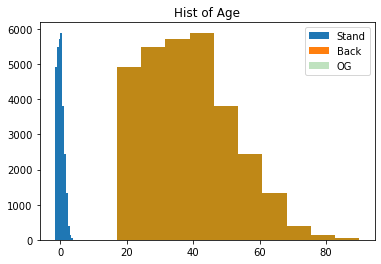

In [237]:
# Standardization. We standardize according to the training data!

def fit_scaler(df):
    return preprocessing.StandardScaler().fit(df)
    # could also use the quantile transformer!

# Fit the scaler to the training data to acquire correct center and scale.
standard_scaler = fit_scaler(X_train[numerical_features]) 

def scale(df,standard_scaler):
    output = df.copy()
    output[numerical_features] = standard_scaler.transform(output[numerical_features])
    return output

def descale(df,standard_scaler):
    output = df.copy()
    output[numerical_features] = standard_scaler.inverse_transform(output[numerical_features])
    return output

# Check if the means and scales of each of the columns are correct. 
# Use this to standardize the validation and testing data as well. 
print(standard_scaler.mean_)
print(standard_scaler.scale_)

print(X_train["age"].mean(), X_train["age"].std())
print(X_train["fnlwgt"].mean(), X_train["fnlwgt"].std())
print(X_train["education_num"].mean(), X_train["education_num"].std())
# The scales are not completely correct! Not sure why?

# Standardize the two other data sets according to the same centering/scaling as the training data. 
X_train2 = scale(X_train, standard_scaler)
X_train3 = descale(X_train2, standard_scaler)
plt.hist(X_train2["age"], label = "Stand")
plt.hist(X_train3["age"], label = "Back")
plt.hist(X_train["age"], label = "OG", alpha = 0.3)
plt.title("Hist of Age")
plt.legend() # Seems to work fine!

In [238]:
# Standardize the training data.
X_train = scale(X_train, standard_scaler)

# Standardize the testing data.
X_test = scale(X_test, standard_scaler)

# Standardize the validation data.
X_valid = scale(X_valid, standard_scaler)

In [239]:
X_train[numerical_features].describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,3.014800e+04,3.014800e+04,3.014800e+04,3.014800e+04,3.014800e+04,3.014800e+04
mean,2.836762e-16,-7.660495e-17,1.999955e-15,-2.867291e-15,-2.319599e-16,-2.162275e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.626807e+00,-1.661913e+00,-3.556085e+00,-1.451010e-01,-2.179503e-01,-3.324091e+00
25%,-7.961289e-01,-6.828592e-01,-4.382345e-01,-1.451010e-01,-2.179503e-01,-7.820890e-02
50%,-1.164830e-01,-1.075839e-01,-4.850312e-02,-1.451010e-01,-2.179503e-01,-7.820890e-02
75%,6.386791e-01,4.546627e-01,1.120691e+00,-1.451010e-01,-2.179503e-01,3.379298e-01
max,3.885876e+00,1.227168e+01,2.289885e+00,1.315431e+01,1.057143e+01,4.832228e+00


In [240]:
descale(X_train, standard_scaler)[numerical_features].describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,30148.00000,3.014800e+04,30148.000000,30148.000000,30148.000000,30148.000000
mean,38.54249,1.896485e+05,10.124453,1091.022788,87.993200,40.939697
std,13.24241,1.059980e+05,2.565913,7519.182124,403.737188,12.015423
min,17.00000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.00000,1.172680e+05,9.000000,0.000000,0.000000,40.000000
50%,37.00000,1.782450e+05,10.000000,0.000000,0.000000,40.000000
75%,47.00000,2.378410e+05,13.000000,0.000000,0.000000,45.000000
max,90.00000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## Should use the Dataloader from Pytorch to get batching

In [241]:
# This can be done as below (for example).

class CustomDataset(Dataset):
    
    def __init__(self, X, y, transform = None, valid = True):
        # Could load the Adult data directly in here. Or could take X, y from Adult data loaded earlier. 
        self.X = X.values.astype(np.float32) # Return a Numpy array with the dataframe contents. 
        self.y = np.reshape(y.values,(len(y.values),1)).astype(np.float32) # Return a Numpy array with the dataframe contents. 
        # Needed to reshape a little above, check that this is correct later!
        
        # use the methods defined below to split the data, scale and one-hot encode directly
        # in the constructor (very smooth!)
        
        self.n_samples = self.X.shape[0]
        self.transform = transform
       
    def __getitem__(self, index):
        sample = self.X[index], self.y[index]
        #return sample
        if self.transform:
            sample = self.transform(sample)
        return sample
   
    def __len__(self):
        return self.n_samples
    
    # Could add a lot more of the preprocessing of the data to this class eventually!
    
    def train_test_valid_split(self, valid=True):
        #split the data into train/test and validation (optional)
        pass
            
    
    def scale(self):
        #scale the numerical data according to the training data. 
        pass
    
    def descale(self):
        #descale the numerical data according to the training data. 
        pass

    def fit_scaler(self):
        #fit the numerical data scaler according to the training data. 
        pass
    
    def encode(self):
        #encode the categorical data (one-hot for now)
        pass
    
    def decode(self):
        #decode the categorical data (from one-hot)
        pass
    
    def fit_encoder(self):
        #fit the encoder to the categorical data features. 
        pass
    
class ToTensor: # Transform to Pytorch tensors. 
    def __call__(self, sample):
        inputs, labels = sample
        #print(labels)
        return torch.from_numpy(inputs), torch.from_numpy(labels)


# select rows from the dataset
train_data = CustomDataset(X_train, y_train, transform = ToTensor()) # Here we put the Adult data loaded in earlier cells into the Dataset type. 

# Check if it works as expected.
nex = train_data[0]
print(nex)
print(type(nex[0]), type(nex[1]))

(tensor([-1.4003, -0.2451, -0.0485, -0.1451, -0.2180, -1.9924,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000]), tensor([0.]))
<class 'torch.Tensor'> <class 'torch.Tensor'>


## Build the Simple Classifier

The classifier will have three dense layers with 18, 9 and 3 units respectively. In addition, it will use ReLU activations in each of the layers and have a sigmoid output activation, since we want to do binary classification of the output.

In [242]:
# Set the hyperparameters.
input_size = X_test.shape[1] # Number of columns in the data.

# Could have used Pytorch sequential for this.
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        
        # Layers. 
        self.l1 = nn.Linear(input_size, 18)
        self.l2 = nn.Linear(18,9)
        self.l3 = nn.Linear(9,3)
        self.output = nn.Linear(3,1)
        
        # Activation functions.
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.output(out)
        out = self.sigmoid(out) 
        return out

model = NeuralNet(input_size).to(device) # Load the neural net onto the gpu.
print(model) # Have a look at the neural network.

NeuralNet(
  (l1): Linear(in_features=88, out_features=18, bias=True)
  (l2): Linear(in_features=18, out_features=9, bias=True)
  (l3): Linear(in_features=9, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## Train the model.

In [243]:
# Some hyperparameters for training. 
num_epochs = 30
batch_size = 1024
learning_rate = 0.01

criterion = nn.BCELoss() # Loss function.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Data for the training. 
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

# Train the model.
n_total_steps = len(train_loader) # Total length of training data. 
train_losses = []
train_accuracies = []

# How can I get validation data in here as well?

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):  
        # Load the data on to the gpu.
        inputs = inputs.to(device)
        y_acc_metric = labels.reshape(-1).numpy() # Used to measure accuracy as a metric below. 
        labels = labels.view(labels.shape[0],1).to(device) 
        
        # Forward pass.
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Accuracy metric reporting. 
        accuracy = (outputs.reshape(-1).cpu().detach().numpy().round() == y_acc_metric).mean()
        
        # Backward and optimize.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if (i+1) % 10 == 0:
            train_losses.append(loss.item())
            train_accuracies.append(accuracy)
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, Acc: {accuracy:.4f}')

Epoch [1/30], Step [10/30], Loss: 0.4979, Acc: 0.7705
Epoch [1/30], Step [20/30], Loss: 0.4078, Acc: 0.7588
Epoch [1/30], Step [30/30], Loss: 0.4600, Acc: 0.7345
Epoch [2/30], Step [10/30], Loss: 0.4169, Acc: 0.7500
Epoch [2/30], Step [20/30], Loss: 0.3865, Acc: 0.7617
Epoch [2/30], Step [30/30], Loss: 0.3903, Acc: 0.7655
Epoch [3/30], Step [10/30], Loss: 0.3761, Acc: 0.7588
Epoch [3/30], Step [20/30], Loss: 0.3864, Acc: 0.7393
Epoch [3/30], Step [30/30], Loss: 0.3506, Acc: 0.7434
Epoch [4/30], Step [10/30], Loss: 0.3648, Acc: 0.8311
Epoch [4/30], Step [20/30], Loss: 0.3580, Acc: 0.8506
Epoch [4/30], Step [30/30], Loss: 0.3581, Acc: 0.8274
Epoch [5/30], Step [10/30], Loss: 0.3397, Acc: 0.8496
Epoch [5/30], Step [20/30], Loss: 0.3641, Acc: 0.8223
Epoch [5/30], Step [30/30], Loss: 0.3199, Acc: 0.8717
Epoch [6/30], Step [10/30], Loss: 0.3405, Acc: 0.8525
Epoch [6/30], Step [20/30], Loss: 0.3555, Acc: 0.8418
Epoch [6/30], Step [30/30], Loss: 0.3451, Acc: 0.8584
Epoch [7/30], Step [10/30], 

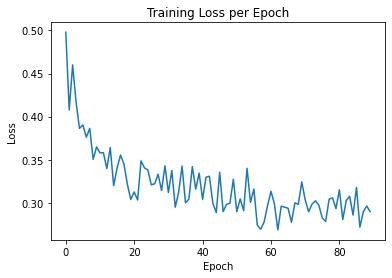

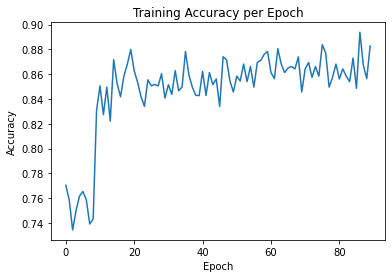

In [244]:
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_accuracies)
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [245]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
test_data = CustomDataset(X_test, y_test, transform = ToTensor())
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 2)

test_steps = len(test_loader)
test_accuracies = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, (inputs, labels) in enumerate(test_loader):
        # Load the data on to the gpu.
        inputs = inputs.to(device)
        y_acc_metric = labels.reshape(-1).numpy() # Used to measure accuracy as a metric below. 
        
        # Forward pass.
        outputs = model(inputs)
        #print(outputs)
        
        # Accuracy metric reporting. 
        accuracy = (outputs.reshape(-1).cpu().detach().numpy().round() == y_acc_metric).mean()
        
    
        test_accuracies.append(accuracy)
        print (f'Step [{i+1}/{test_steps}], Acc: {accuracy:.4f}')
        
print(f"Average test accuracy over all batches: {sum(test_accuracies)/len(test_accuracies):.4f}")

Step [1/10], Acc: 0.8525
Step [2/10], Acc: 0.8584
Step [3/10], Acc: 0.8525
Step [4/10], Acc: 0.8574
Step [5/10], Acc: 0.8486
Step [6/10], Acc: 0.8516
Step [7/10], Acc: 0.8379
Step [8/10], Acc: 0.8662
Step [9/10], Acc: 0.8398
Step [10/10], Acc: 0.8415
Average test accuracy over all batches: 0.8507


Unique predicted values: [2.1751780e-06 2.8760046e-06 3.2837161e-06 ... 8.9783770e-01 8.9790648e-01
 8.9799106e-01]


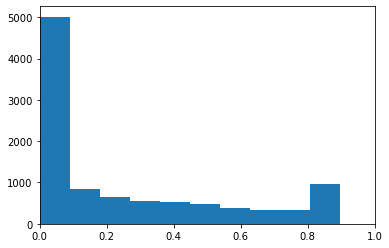

In [251]:
# Test on entire test data set at once.
with torch.no_grad():
    test_dat = torch.from_numpy(X_test.values.astype(np.float32)).to(device)
    test_labs = torch.from_numpy(y_test.values.astype(np.float32))
    test_labs = test_labs.view(test_labs.shape[0],1)
    
    predicted_probs = model(test_dat).cpu().numpy()
    
    plt.hist(predicted_probs.flatten())
    plt.xlim(0,1)
    print(f"Unique predicted values: {np.unique(predicted_probs.flatten())}")

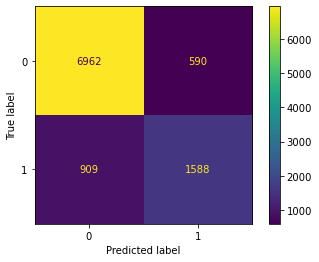

Some more classifaction statistics:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7552
           1       0.73      0.64      0.68      2497

    accuracy                           0.85     10049
   macro avg       0.81      0.78      0.79     10049
weighted avg       0.85      0.85      0.85     10049



In [247]:
# Confusion matrix.
labs = list(y_test.values)
preds = predicted_probs.flatten()
predicted_classes = list(np.where(preds > 0.5, 1, 0))
cm = metrics.confusion_matrix(labs, predicted_classes, labels = [0,1])
conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
conf_mat.plot()
plt.show()

print("Some more classifaction statistics:")
print(metrics.classification_report(labs, predicted_classes, labels = [0,1]))

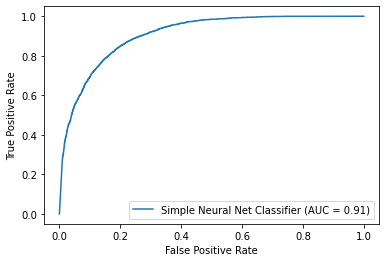

In [248]:
# Make roc and auc below. 
fpr, tpr, thresholds = metrics.roc_curve(labs, predicted_probs.flatten())
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Simple Neural Net Classifier')
display.plot()
plt.show()

In [249]:
# In case I want to save the trained model.
PATH = './mymodel.pth'
#torch.save(model.state_dict(), PATH)

In [250]:
# Load the weights and biases (with the same structure as the model used here).
#model = NeuralNet(input_size).to(device)
#model.load_state_dict(torch.load(PATH))

# Perhaps we could follow [this](https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch) tutorial.

Or [this](https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2) is even better I believe. And [this](https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43).
